# 1 - Interacting with the Fitbit API

In this section we will be using the python-fitbit and the requests modules to get data from the Fitbit API. This is not the only way to do it, for example, a simple alternative would be to use the Fitbit Web API Explorer (https://dev.fitbit.com/build/reference/web-api/explore/). The steps taken here are largely outlined in this (https://towardsdatascience.com/using-the-fitbit-web-api-with-python-f29f119621ea) Towards Data Science article.

## 1.1 Setting up 

In this section we load all necessary modules, proceed with the authorization from the Fitbit API and also define the Fitbit object (from the python-fitbit module) which is used to make some GET requests to the Fitbit API.

In [1]:
# Import necessary modules
import gather_keys_oauth2 as Oauth2 # This is a python file you need to have in the same directory as your code so you can import it
import fitbit
import pandas as pd 
from datetime import datetime
import requests

# Enter CLIENT_ID and CLIENT_SECRET
CLIENT_ID = '23QRRC'
CLIENT_SECRET = '51922a48a2df4434cc20afaac4ee97b8'

# Date after which we have data
START_DATE = "2023-03-29"

Upon execution of the cell below, you will be redirected to another tab and will be asked to login into your Fitbit account. Upon doing that you will see a page that should say something like "Authentication Complete, you may close this tab".

In [2]:
# Authorize user
server=Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()
# Save access and refresh tokens
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])
EXPIRES_AT = str(server.fitbit.client.session.token['expires_at'])

[28/Apr/2023:21:55:37] ENGINE Listening for SIGTERM.
[28/Apr/2023:21:55:37] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[28/Apr/2023:21:55:37] ENGINE Set handler for console events.
[28/Apr/2023:21:55:37] ENGINE Started monitor thread 'Autoreloader'.
[28/Apr/2023:21:55:37] ENGINE Serving on http://127.0.0.1:8080
[28/Apr/2023:21:55:37] ENGINE Bus STARTED


127.0.0.1 - - [28/Apr/2023:21:56:13] "GET /?code=f892804f0fcacda2af8a63acaa040f528f989c20&state=Fo234FLPT4eaJuHkT05s10DjRkcjKv HTTP/1.1" 200 122 "" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36"
127.0.0.1 - - [28/Apr/2023:21:56:13] "GET /favicon.ico HTTP/1.1" 200 1406 "http://127.0.0.1:8080/?code=f892804f0fcacda2af8a63acaa040f528f989c20&state=Fo234FLPT4eaJuHkT05s10DjRkcjKv" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36"


[28/Apr/2023:21:56:14] ENGINE Bus STOPPING
[28/Apr/2023:21:56:14] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[28/Apr/2023:21:56:14] ENGINE Stopped thread 'Autoreloader'.
[28/Apr/2023:21:56:14] ENGINE Removed handler for console events.
[28/Apr/2023:21:56:14] ENGINE Bus STOPPED
[28/Apr/2023:21:56:14] ENGINE Bus EXITING
[28/Apr/2023:21:56:14] ENGINE Waiting for child threads to terminate...
[28/Apr/2023:21:56:14] ENGINE Bus EXITED
[28/Apr/2023:21:56:14] ENGINE Waiting for thread Thread-16.


In the previous cells we completed the authorization process for the Id and Secret that is specified in the first code block. Next, we create an instance of the Fitbit object of the python-fitbit module, which will be the base object we will use to get the data we want.

In [3]:
# Create Fitbit object which will be used to get the data
auth2_client = fitbit.Fitbit(client_id = CLIENT_ID,
                             client_secret = CLIENT_SECRET,
                             expires_at = EXPIRES_AT,
                             oauth2 = True,
                             access_token = ACCESS_TOKEN,
                             refresh_token = REFRESH_TOKEN)

## 1.2 Get data

To get Sleep related data, we will be using the requests module. The reason for that is that for some reason in the python-fitbit module, there is an older API version variable that is hardcoded and we cannot change it (it's 1 while it should be 1.2 for Sleep data). As far as we know there is an issue about that in the module's Github page, but no implemented solution.

Therefore what we did is that we used the Fitbit Web API Explorer to get the CURL of the endpoint we want to draw data from, converted it to python using the requests module, and get the data we want.

For Activity data we used the python-fitbit module. We have used several different resources to quantify activity (steps, minutes active/sedentary).


In [4]:
def get_sleep_data(date):
    """
    Inputs:
        - date <str> (yyyy-mm-dd): Date for which we want to pull data.
        
    Returns the data related to sleep for <date> from the Fitbit API. 
    """
    
    # Check date value
    global START_DATE
    global ACCESS_TOKEN
    if datetime.strptime(date, '%Y-%m-%d') < datetime.strptime(START_DATE, '%Y-%m-%d'):
        raise ValueError("date cannot be before {}".format(START_DATE))
    
    # Make API get request
    headers = {
        'accept': 'application/json',
        'authorization': 'Bearer {}'.format(ACCESS_TOKEN),
    }

    response = requests.get('https://api.fitbit.com/1.2/user/-/sleep/date/{}.json'.format(date), 
                            headers=headers)

    return response.json()


def get_activity_data(date):
    """
    Inputs:
        - date <str> (yyyy-mm-dd): Date we want the data of.
    
    Returns activity data for the specified date. Activity is quantified in terms of the elements of the resources list
    that is defined inside the function.
    """
    
    # Check date value
    global START_DATE
    if datetime.strptime(date, '%Y-%m-%d') < datetime.strptime(START_DATE, '%Y-%m-%d'):
        raise ValueError("date cannot be before {}".format(START_DATE))
   
    # Dictionary where data returned by the API will be stored
    data = {}

    # Different kinds of resources that quantify activity
    resources = [
        "minutesSedentary",
        "minutesLightlyActive",
        "minutesFairlyActive",
        "minutesVeryActive",
        "steps"
    ]
    
    # A separate API call is made for each resource
    for resource in resources:
        resourceString = "activities/" + resource
        # detailString can be one of 1min, 5min, 15min
        if resource == "steps":
            # Thought this might make more sense, feel free to change it if you think otherwise
            detailString = "1min"
        else:
            detailString = "15min"
        
        # Use fitbit module to make the API get request
        data[resource] = auth2_client.intraday_time_series(resourceString,
                                                           date,
                                                           detail_level = detailString)
        
    return data


In [5]:
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

### Example code on how to get and transform sleep data. Just for reference. (source: https://towardsdatascience.com/using-the-fitbit-web-api-with-python-f29f119621ea)

## General example - ignore

This is just an example of how to get data in general. Can be deleted, left it here for reference.

In [10]:
# This is the date of data that I want. 
# You will need to modify for the date you want
oneDate = pd.datetime(year = 2023, month = 3, day = 30)
# Example
oneDayData = auth2_client.intraday_time_series('activities/heart', oneDate, detail_level='1sec')

/tmp/ipykernel_21421/3526614276.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  oneDate = pd.datetime(year = 2023, month = 3, day = 30)


In [ ]:
oneDayData

In [12]:
df = pd.DataFrame(oneDayData['activities-heart-intraday']['dataset'])
# Convert obj dtype to datetime object
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.strftime('%H:%M:%S')
# Make time the df index
df = df.set_index('time')

In [13]:
df.head()

,value
time,
00:00:03,92
00:00:13,91
00:00:23,93
00:00:38,93
00:00:43,92


<Axes: xlabel='time'>

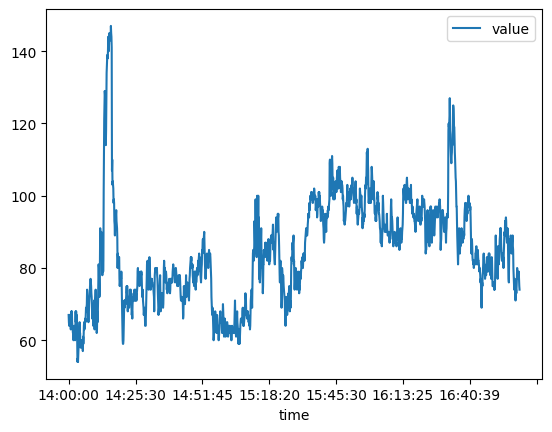

In [14]:
start_time = '14:00:00'
end_time = '17:00:00'

df[start_time:end_time].plot()

# 2 - Import data into MongoDB

In [16]:
#!pip install pymongo

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 1.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 2.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [6]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

USER_UUID = "3cc4e2ee-8c2f-4c25-955b-fe7f6ffcbe44"

In [7]:
try:
    # Check if the connection was successful
    db = client.admin
    server_info = db.command('serverStatus')
    print('Connection to MongoDB server successful.')
    
except pymongo.errors.ConnectionFailure as e:
    print('Connection to MongoDB server failed: %s' % e)

Connection to MongoDB server successful.


In [8]:
client.drop_database("fitbit")

# mydb = client["fitbit"]
# mycollection = mydb["fitbitCollection"]
# mycollection.drop()

## Import Sleep data to mongo

### TODO: Add checks to avoid any exception due to missing data

In [9]:
try:
    # Create a new database called "fitbit"
    fitbitDb = client['fitbit']

    # Create a new collection called "fitbitCollection"
    fitbitCollection = fitbitDb['fitbitCollection']
    skipKeys = ["levels", "infoCode", "logId", "logType", "type", "dateOfSleep"]
    
    # Insert a new document into the collection
    start_date = date(2023, 3, 29)
    end_date = date(2023, 4, 23)
    for single_date in daterange(start_date, end_date):
        sleepDateTime = single_date.strftime("%Y-%m-%d")
        oneDaySleepData = get_sleep_data(sleepDateTime)
        if (len(oneDaySleepData["sleep"]) > 0) :
            sleepData = oneDaySleepData["sleep"][0]
        else:
            print("Could not find sleep data for date {}".format(sleepDateTime))
            continue
        global USER_UUID
        for data in sleepData.keys():
            if data not in skipKeys:
                mydocument = {}
                mydocument["id"] = USER_UUID
                mydocument["type"] = "sleep-{}".format(data)
                if "data" not in mydocument:
                    mydocument["data"] = {}
                mydocument["data"]["dateTime"] = sleepDateTime
                mydocument["data"]["value"] = sleepData[data]
                result = fitbitCollection.insert_one(mydocument)
        
                # Check if the document was inserted successfully
                if not result.inserted_id:
                    print('Failed to insert document.')

        sleepLevelsData = sleepData["levels"]
        for key in sleepLevelsData.keys():
            if key == "data" or key == "shortDate":
                for data in sleepLevelsData[key]:            
                    mydocument = {}
                    mydocument["id"] = USER_UUID
                    mydocument["type"] = "sleepLevelsData"
                    mydocument["data"] = {}
                    for val in data.keys():
                        mydocument["data"][val] = data[val]
                    # mydocument["data"]["level"] = sleepLevelsData["level"]
                    # mydocument["data"]["seconds"] = sleepLevelsData["seconds"]
                    result = fitbitCollection.insert_one(mydocument)
                    
                    # Check if the document was inserted successfully
                    if not result.inserted_id:
                        print('Failed to insert document.')
            else:
                for sumKey in sleepLevelsData["summary"].keys():
                    mydocument = {}
                    mydocument["id"] = USER_UUID
                    mydocument["type"] = "sleepLevelsSummary-{}".format(sumKey)
                    mydocument["data"] = {}
                    mydocument["data"]["dateTime"] = sleepDateTime
                    for data in sleepLevelsData["summary"][sumKey]:        
                        mydocument["data"][data] = sleepLevelsData["summary"][sumKey][data]
                    result = fitbitCollection.insert_one(mydocument)
                    
                    # Check if the document was inserted successfully
                    if not result.inserted_id:
                        print('Failed to insert document.')
                        
        sleepSummaryData = oneDaySleepData["summary"]
        for key in sleepSummaryData.keys():
            mydocument = {}
            mydocument["id"] = USER_UUID
            mydocument["type"] = "sleepSummary-{}".format(key)
            mydocument["data"] = {}
            mydocument["data"]["dateTime"] = sleepDateTime
            if key == "stages":
                for data in sleepSummaryData[key].keys():
                    mydocument["data"][data] = sleepSummaryData[key][data]
            else:
                mydocument["data"][key] = sleepSummaryData[key]
            result = fitbitCollection.insert_one(mydocument)
            
            # Check if the document was inserted successfully
            if not result.inserted_id:
                print('Failed to insert document.')
         
except Exception as e:
    print('Error: %s' % e)

Could not find sleep data for date 2023-04-03


## Import Activity data to mongo


In [10]:
try:
    # Create a new database called "fitbit"
    fitbitDb = client['fitbit']

    # Create a new collection called "fitbitCollection"
    fitbitCollection = fitbitDb['fitbitCollection']
    # skipKeys = ["datasetInterval", "datasetType"]
    
    # Insert a new document into the collection
    start_date = date(2023, 3, 29)
    end_date = date(2023, 4, 23)
    for single_date in daterange(start_date, end_date):
        date = single_date.strftime("%Y-%m-%d")
        oneDayActivityData = get_activity_data(date)
        global USER_UUID
        for key in oneDayActivityData.keys():
            for innerKey in oneDayActivityData[key].keys():
                if "intraday" not in innerKey and len(oneDayActivityData[key][innerKey]) > 0:
                    mydocument = {}
                    mydocument["id"] = USER_UUID
                    mydocument["type"] = innerKey
                    mydocument["data"] = {}
                    mydocument["data"]["dateTime"] = oneDayActivityData[key][innerKey][0]["dateTime"]
                    mydocument["data"]["value"] = oneDayActivityData[key][innerKey][0]["value"]
                    result = fitbitCollection.insert_one(mydocument)
            
                    # Check if the document was inserted successfully
                    if not result.inserted_id:
                        print('Failed to insert document.')
                else:
                    for data in oneDayActivityData[key][innerKey]["dataset"]:
                        mydocument = {}
                        mydocument["id"] = USER_UUID
                        mydocument["type"] = innerKey
                        mydocument["data"] = {}
                        for datakey in data.keys():
                            if datakey == "time":
                                mydocument["data"]["dateTime"] = "{}T{}".format(date, data[datakey])
                            else:
                                mydocument["data"]["value"] = data[datakey]
                    
                        result = fitbitCollection.insert_one(mydocument)

                        # Check if the document was inserted successfully
                        if not result.inserted_id:
                            print('Failed to insert document.')
                               
except Exception as e:
    print('Error: %s' % e)

In [ ]:
myquery = { 'data.dateTime': {'$regex':'^2023' } }
mydoc = fitbitCollection.find(myquery)

for doc in mydoc:
    print(doc)

### Streamlit Code


In [ ]:
#!pip install streamlit

# it should be also installed in the terminal by using sudo pip install streamlit

In [29]:
# import requests

# # Set up the parameters for the subscription
# resource_path = '/apiSubscriptions/320.json'  # Sleep resource path
# callback_url = 'https://127.0.0.1:8080'  # Your callback URL

# # Subscribe to the sleep resource
# response = requests.post(f'https://api.fitbit.com/1/user/{CLIENT_ID}/apiSubscriptions/320.json', headers={
#     'Authorization': f'Bearer {ACCESS_TOKEN}'
# }, json={
#     'callbackUrl': callback_url
# })
# # verify_token = response.json()['verifyToken']
# # subscriber_id = response.json()['subscriberId']
# # subscription_id = response.json()['subscriptionId']

In [30]:
# response.json()

{'errors': [{'errorType': 'insufficient_permissions',
   'message': 'API client is not authorized by the resource owner to access the resource requested. Visit https://dev.fitbit.com/docs/oauth2 for more information on the Fitbit Web API authorization process.'}],
 'success': False}